In [1]:
import pandas as pd

In [2]:
tracks_and_features_df = pd.read_csv("SpotifySongs.csv")

In [3]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [4]:
import umap
import numpy as np
import plotly.graph_objects as go

In [5]:
import time
import warnings

In [6]:
# ============
# Set up cluster parameters
# ============
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 10,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

In [9]:
track_feature_cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]
track_metadata_cols = [
    "track:name",
    "track:artists:0:name"
]


/opt/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.



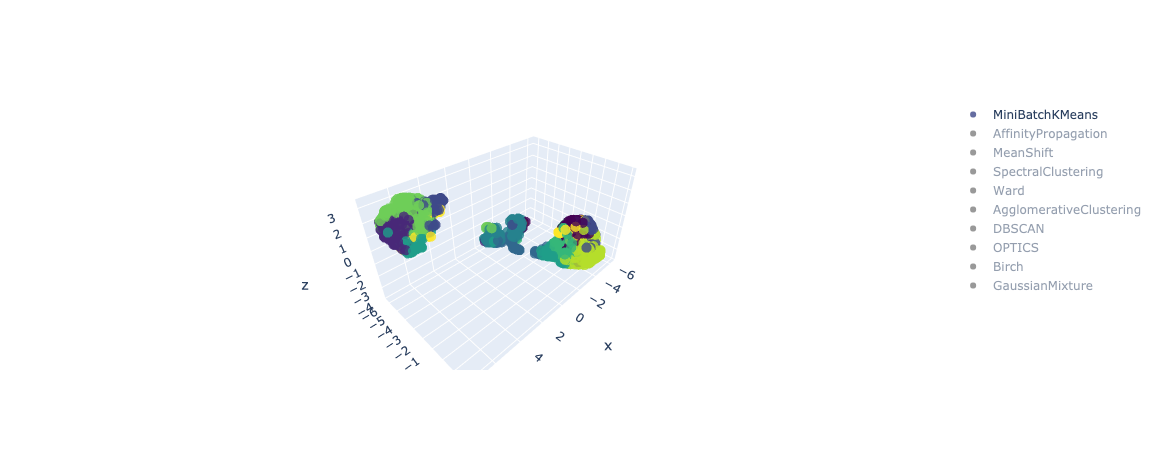

In [11]:
# plt.figure(figsize=(9 * 2 + 3, 12.5))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                     hspace=.01)

datasets = [(tracks_and_features_df, {}, track_feature_cols, track_metadata_cols)]
plot_num = 1

fig = go.Figure()

for i_dataset, (dataset, algo_params, feature_cols, metadata_cols) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X = dataset[feature_cols]

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    #Create embedding for plotting purposes as matrix is very sparse
    #Using UMAP algorithm
    if X.shape[1] == 3:
        x, y, z = X[:,0], X[:,1], X[:,2]
    else:
        embedding = umap.UMAP(n_components=3, random_state=42).fit_transform(X)
        x, y, z = embedding[:,0], embedding[:,1], embedding[:,2]
    
    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in tqdm(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        if plot_num==1:
            visible=True
            plot_num+=1
        else:
            visible="legendonly"
        
        fig.add_trace(go.Scatter3d(
                        x=x,
                        y=y,
                        z=z,
                        mode='markers',
                        marker=dict(
                            size=6,
                            color=y_pred,                # set color to an array/list of desired values
                            colorscale='Viridis',   # choose a colorscale
                            opacity=0.8
                        ),
                        name=name,
                        visible=visible
                    ))
fig.show()